##### ***yellow page 크롤링 전 VPN프로그램 사용으로 로컬 ip주소를 미국 내 ip주소로 변경해야 접속가능***

-----------------

##### 1. 필요한 라이브러리 및 패키지 임포트

In [1]:
import pandas as pd
import numpy as np

# selenium의 webdriver를 사용하기 위한 import
from selenium import webdriver

# selenium으로 키를 조작하기 위한 import
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

# 페이지 로딩을 기다리는데에 사용할 time 모듈 import
import time

import csv
from bs4 import BeautifulSoup as bs
import requests
import math

import re
import urllib.request
import json
import datetime

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException
from selenium .webdriver.chrome.service import Service
from selenium.webdriver.common.proxy import Proxy, ProxyType # 프록시 우회 

import random

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

##### 2. 현재 ip주소 확인

In [14]:
response = requests.get('https://api.ipify.org')
print('My public IP address is:', response.text)

My public IP address is: 193.19.109.109


##### 3. 위치 검색에 입력할 미국 51개 지역 설정

In [17]:
states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 
    'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 
    'District of Columbia'
]

In [18]:
states_code = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC'
]

##### 4. 크롤러

In [20]:
def crawler(state):
    base_url = 'https://www.yellowpages.com/search?search_terms=taekwondo&geo_location_terms=' + state
    r = requests.get(base_url,headers={"User-Agent": "Mozilla/5.0"})
    soup = bs(r.text, "html.parser")

    # MAX_PAGE추출
    last_content=soup.find('span', {'class': "showing-count"})
    if last_content.find('span', {'class': 'result-info'}):
        last_content.find('span', {'class': 'result-info'}).decompose()
    last_content_num = int(last_content.text.split('of')[-1].strip())
    if last_content_num%30 == 0:
        max_page = last_content_num//30
    else:
        max_page = (last_content_num //30) +1
    
    results = []

    for page in range(1,max_page+1):
        url = base_url + '&page=' + str(page)
        res = requests.get(url,headers={"User-Agent": "Mozilla/5.0"})
        soup = bs(res.text, "html.parser")
        time.sleep(random.randint(0, 3))

        gyms = soup.find_all('div', {'class': "v-card"}) # 각 업체 정보

        for gym in gyms:
            gym_data = {'state': state, 'name': np.nan, 'detail_address': np.nan, 'address': np.nan, 'phone': np.nan, 'web': np.nan}
            try:
                name = gym.find('a', {'class': "business-name"}) # 업체명 정보
                detail_add = gym.find('div', {'class': "street-address"}) # 주소 정보 1
                add = gym.find('div', {'class': "locality"}) # 주소 정보 2
                phone = gym.find('div', {'class': "phones phone primary"}) # 연락처 정보

                gym_data['name'] = name.text if name else np.nan
                gym_data['detail_address'] = detail_add.text if detail_add else np.nan
                gym_data['address'] = add.text.strip() if add else np.nan
                gym_data['phone'] = phone.text if phone else np.nan

                link_div = gym.find('div', {'class': "links"}) # 홈페이지 링크 정보
                if link_div:
                    link_a = link_div.find('a')
                    if link_a:
                        data_analytics = link_a.get('data-analytics')
                        if data_analytics:
                            gym_data['web'] = json.loads(data_analytics).get('dku')
                            
            except Exception as e:
                print(f"Error extracting data: {e}")

            results.append(gym_data)

    df = pd.DataFrame(results)
    
    return df

- 위치 검색값에 따라 states/states_code 변경 

In [21]:
dfs = {} # 위치는 key, 해당 위치의 수집된 업체들은 value로 저장되는 구조의 딕셔너리 생성

for state in states_code:
    try:
        df = crawler(state)
        dfs[f'{state}'] = df.copy()
        print(f"Data for {state} collected successfully.")

    except Exception as e: # 예외처리
        print(f"Error extracting data: {e}")

Data for AL collected successfully.
Data for AK collected successfully.
Data for AZ collected successfully.
Data for AR collected successfully.
Data for CA collected successfully.
Data for CO collected successfully.
Data for CT collected successfully.
Data for DE collected successfully.
Data for FL collected successfully.
Data for GA collected successfully.
Data for HI collected successfully.
Data for ID collected successfully.
Data for IL collected successfully.
Data for IN collected successfully.
Data for IA collected successfully.
Data for KS collected successfully.
Data for KY collected successfully.
Data for LA collected successfully.
Data for ME collected successfully.
Data for MD collected successfully.
Data for MA collected successfully.
Data for MI collected successfully.
Data for MN collected successfully.
Data for MS collected successfully.
Data for MO collected successfully.
Data for MT collected successfully.
Data for NE collected successfully.
Data for NV collected succes

##### 5. 중복 제거 전 데이터 저장

In [22]:
pre_taekwondo_df = pd.concat(dfs.values(), ignore_index=True) # 지역별 데이터 통합
pre_taekwondo_df

,state,name,detail_address,address,phone,web
0,AL,McLean's Martial Arts And Fitness,1490 Celeste Rd,"Saraland, AL 36571",(251) 675-9662,http://www.mcleansmartialarts.com
1,AL,Fairfield Taekwondo,5126 Valley Rd,"Fairfield, AL 35064",(205) 903-8399,NaN
2,AL,Trent Graham's Tae-Kwon-DO Acd,1106 Avalon Ave,"Muscle Shoals, AL 35661",(256) 764-0027,http://www.grahamtkd.com
3,AL,Docarmo's Taekwondo Center,3179 Taylor Rd,"Montgomery, AL 36116",(334) 239-7006,http://www.trytkdfree.com
4,AL,Northport Taekwondo Academy Inc,1 Resource Ln,"Northport, AL 35473",(205) 339-7071,https://baileystkd.com/contact-us
...,...,...,...,...,...,...
31983,DC,D C Martial Arts Academy,6950 Wisconsin Ave,"Chevy Chase, MD 20815",(301) 652-7663,NaN
31984,DC,All Star Tae Kwon DO,3223 Duke St,"Alexandria, VA 22314",(703) 370-5425,http://leadbyexampletaekwondo.com
31985,DC,Be Ryong Martial Arts,212 W Glebe Rd,"Alexandria, VA 22305",(703) 535-3334,https://www.beryong.com
31986,DC,Onekick Martial Arts of Alexandria,364 S Pickett St,"Alexandria, VA 22304",(703) 751-0000,http://www.onekickma.com


In [23]:
pre_taekwondo_df.to_excel('pre_taekwondo.xlsx', index=False)

-----------------------

##### 6. 중복제거(업체명, 주소, 연락처가 모두 일치하는 경우 중복처리)

In [204]:
taekwondo_df = taekwondo_df.drop_duplicates(subset=['name','detail_address','address','phone'] ,ignore_index=True)
taekwondo_df

,state,name,detail_address,address,phone,web
0,AL,McLean's Martial Arts And Fitness,1490 Celeste Rd,"Saraland, AL 36571",(251) 675-9662,http://www.mcleansmartialarts.com
1,AL,Fairfield Taekwondo,5126 Valley Rd,"Fairfield, AL 35064",(205) 903-8399,NaN
2,AL,Trent Graham's Tae-Kwon-DO Acd,1106 Avalon Ave,"Muscle Shoals, AL 35661",(256) 764-0027,http://www.grahamtkd.com
3,AL,Docarmo's Taekwondo Center,3179 Taylor Rd,"Montgomery, AL 36116",(334) 239-7006,http://www.trytkdfree.com
4,AL,Northport Taekwondo Academy Inc,1 Resource Ln,"Northport, AL 35473",(205) 339-7071,https://baileystkd.com/contact-us
...,...,...,...,...,...,...
31712,DC,DC Self Defense Karate Association,1755 Newton St NW,"Washington, DC 20010",NaN,http://www.dcsdka.net
31713,DC,Aikido Shobukan Dojo,421 Butternut St NW,"Washington, DC 20012",(202) 829-4202,https://aikidoshobukan.org/about/facilities/th...
31714,DC,Wash Karate Acdmy Inc,1045 Wisconsin Ave NW,"Washington, DC 20007",(202) 537-6124,NaN
31715,DC,Japan Karate Assn-Iskf,3265 S St NW,"Washington, DC 20007",(202) 462-0385,NaN


##### 7. 데이터 확인(위치 설정값과 크롤링한 업체 주소내 지역 코드가 일치하는지)

In [217]:
check_df1 = taekwondo_df.copy()
check_df1['check_col'] = check_df1['address'].str.split(' ').str[-2] # 업체 주소내 지역 코드 추출
check_df2 = check_df1[check_df1['check_col'] != check_df1['state']] # 위치 설정값과 지역이 일치하지 않는 데이터 추출

,state,name,detail_address,address,phone,web,check_col
155,AL,The Tradition School of Karate,Hwy 31 North,"Athens, 35611",(256) 444-0171,NaN,
11732,KY,Travis Martial Arts Studio,708 S Dixie Highway,"Muldraugh, AL 40175",(502) 551-4849,https://www.facebook.com/TravisMAStudio,AL
13164,MA,Tim Burrill Brazilian Jiu Jitsu,55 Porter St,"Providence, RI 02905",(401) 374-5759,http://www.timburrill.com,RI
18485,NM,Han's Oriental Martial Arts,9861 Dyer St,"El Paso, TX 79924",(915) 229-8291,https://hansorientalmartialartstx.mydex.com/8d...,TX


In [221]:
# check_df 확인 후 수정
taekwondo_df.loc[11732,'state'] = 'AL'
taekwondo_df.loc[13164,'state'] = 'RI'
taekwondo_df.loc[18485,'state'] = 'TX'

##### 8. 데이터 저장

In [226]:
taekwondo_df.to_excel('usa_taekwondo.xlsx', index=False)

----------------------

##### 9. 데이터 확인

In [2]:
df = pd.read_excel('usa_taekwondo.xlsx') # 전처리 완료 데이터
pre_df = pd.read_excel('pre_taekwondo.xlsx') # 전처리 전 데이터

In [3]:
df.isnull().sum() # 컬럼별 결측값 확인

state                 0
name                  0
detail_address      925
address             347
phone                14
web               15759
dtype: int64

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

pre_state_counts = pre_df['state'].value_counts()
state_counts = df['state'].value_counts()

comparison_df = pd.DataFrame({'전처리 전 태권도장 수': pre_state_counts, '전처리 이후 태권도장 수': state_counts})

comparison_df = comparison_df.sort_values(by='전처리 전 태권도장 수', ascending= False) # 전처리 전 업체 개수 기준 내림차순 정렬
different_values = comparison_df[comparison_df['전처리 전 태권도장 수'] != comparison_df['전처리 이후 태권도장 수']].reset_index() # 전처리 전후 업체개수가 다른 지역만 추출

different_values

,state,전처리 전 태권도장 수,전처리 이후 태권도장 수
0,CA,3000,2989
1,FL,2627,2517
2,TX,2594,2590
3,NY,2294,2292
4,PA,1351,1350
5,MA,1064,1062
6,GA,987,981
7,OH,953,943
8,NC,953,952
9,CO,861,831


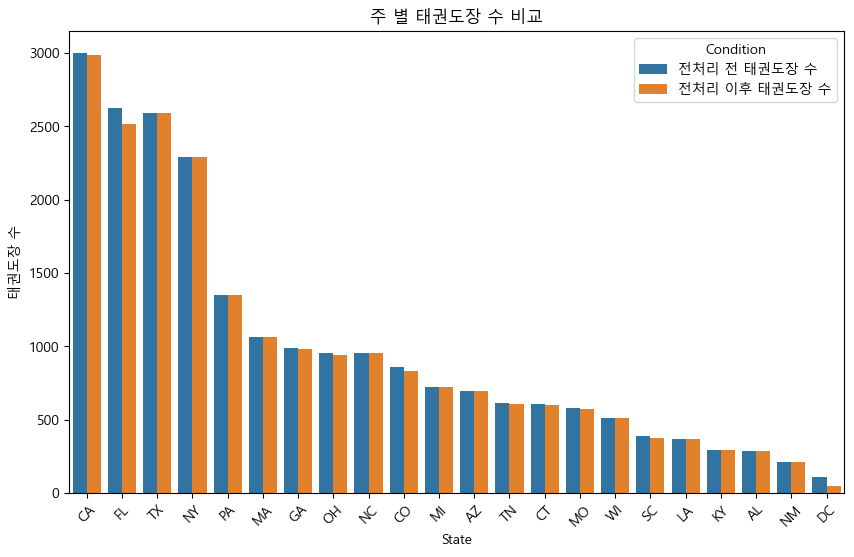

In [62]:
# 데이터프레임을 재구조화하여 'hue' 매개변수를 사용할 수 있게 준비
melted_df = pd.melt(different_values, id_vars=['state'], value_vars=['전처리 전 태권도장 수', '전처리 이후 태권도장 수'], var_name='Condition', value_name='Count')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x='state', y='Count', hue='Condition')
plt.xlabel('State')
plt.ylabel('태권도장 수')
plt.title('주 별 태권도장 수 비교')
plt.xticks(rotation=45)
plt.show()

------------------

##### 99. 프록시 변경으로 우회

In [ ]:
# #헤더 변경으로 크롤링 차단 우회
# HEADERS = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0",
#     "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
#     "Accept-Encoding": "gzip, deflate, br",
#     "Connection": "keep-alive",
#     "Upgrade-Insecure-Requests": "1",
#     "TE": "Trailers",
#     "DNT": "1",
# }


# # 미국 프록시 서버를 랜덤으로 가져오는 함수
# def random_us_proxy():
    
#     proxy_url = "https://www.us-proxy.org/" 

#     r = requests.get(proxy_url)
#     soup = bs(r.text, 'lxml')

#     table = soup.find('tbody')
#     rows = table.find_all('tr')
#     proxy_server_list = []

#     for row in rows:
#         https = row.find('td', attrs = {'class':'hx'})
#         if https.text == 'yes':
#             ip = row.find_all('td')[0].text
#             port = row.find_all('td')[1].text
#             server = f"{ip}:{port}"
#             proxy_server_list.append(server)

#     proxy_server = random.choices(proxy_server_list)[0]
#     return proxy_server

In [ ]:
# proxy_server = random_us_proxy()
# proxies = {"http": 'http://' + proxy_server, 'https': 'http://' + proxy_server}

# try:
#     r = requests.get(url, headers=HEADERS, proxies=proxies, verify=False)
#     r.raise_for_status()
#     soup = bs(r.text, "html.parser")
# except requests.exceptions.RequestException as e:
#     print(f"An error occurred: {e}")